## Requirements

In [20]:
import nltk
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve


import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

## Data loader and split

In [21]:
dataset = pd.read_csv('data/cleaned_dataset_processed_balanced.csv').sample(n=4000, random_state=42)
print(dataset.head(5))
print(dataset.shape)


                                                  review  rating  \
11368  great hotel just returned hotel stayed 24.08 3...       4   
2605   not worth price stayed whirlpool suite 269 nig...       3   
4518   great location clean rooms reviewers hotel gre...       4   
10638  service service, arrived renaissance friday ex...       2   
1962   Title: A Comfortable yet Imperfect Overnight D...       2   

                                          cleaned_review  
11368  great returned originally petite double tight ...  
2605   not worth price whirlpool suite nice worth pri...  
4518   great location clean reviewers great bargain l...  
10638  service service arrived renaissance friday exp...  
1962   title comfortable yet imperfect overnight rece...  
(4000, 3)


In [22]:
def split_data_stratified(X, y, test_size=0.2, random_state=42):
    """
    Split data ensuring proportional representation of all classes
    """
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    
    # Get indices for train and test splits
    for train_idx, test_idx in sss.split(X, y):
        X_train = X.iloc[train_idx]
        X_test = X.iloc[test_idx]
        y_train = y.iloc[train_idx]
        y_test = y.iloc[test_idx]
    
    print("Class distribution in splits:")
    print("\nTraining set:")
    print(y_train.value_counts().sort_index())
    print("\nTest set:")
    print(y_test.value_counts().sort_index())
    
    return X_train, X_test, y_train, y_test

In [23]:
X = dataset['cleaned_review']
y = dataset['rating']

X_train, X_test, y_train, y_test = split_data_stratified(X, y)

Class distribution in splits:

Training set:
rating
1     416
2     518
3     397
4     790
5    1079
Name: count, dtype: int64

Test set:
rating
1    104
2    130
3     99
4    197
5    270
Name: count, dtype: int64


## Functions and pipelines

XGBoost is commented due to its high cpu processing requirements that, for a quick test, is not needed. In order to enable it again uncomment xgboost in param_grid and in pipelines within compare_models_with_grid_search function.

In [24]:
def create_param_grids():
    """Define parameter grids for each model"""
    param_grids = {
        'Logistic Regression': {
            'vectorizer__max_features': [800, 1000, 2000, 3000, 4000, 5000, 8000],
            'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
            'classifier__C': [0.1, 1.0, 10.0, 12.0],
        },
        'SVM': {
            'vectorizer__max_features': [1000, 2000, 3000, 4000, 5000, 10000, 12000],
            'vectorizer__ngram_range': [(1,1), (1,2), (1,3)],
            'classifier__estimator__C': [0.1, 1.0, 10.0, 12.0],
        },
        'Random Forest': {
            'vectorizer__max_features': [1000, 2000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [10, 20, None],
        },
        #'XGBoost': {
        #    'vectorizer__max_features': [2000, 3000],
        #    'vectorizer__ngram_range': [(1,1), (1,2)],
        #    'classifier__n_estimators': [100, 200, 300],
        #    'classifier__max_depth': [3, 5, 6],
        #    'classifier__learning_rate': [0.01, 0.1, 0.05],
        #},
        'Naive Bayes': {
            'vectorizer__max_features': [1000, 2000, 3000],
            'vectorizer__ngram_range': [(1,1), (1,2)],
            'classifier__alpha': [0.1, 0.5, 1.0],
        }
    }
    return param_grids

In [25]:


def plot_learning_curves(estimator, title, X, y, ylim=None, cv=5,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Plot learning curves for a given estimator"""
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1,
                     color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

def plot_grid_search_results(grid_search, param_name):
    """Plot grid search results for a specific parameter"""
    # Clear any existing plots
    plt.clf()
    
    results = pd.DataFrame(grid_search.cv_results_)
    
    # Get the parameter values
    param_values = [params[param_name] for params in results['params']]
    
    # Calculate mean scores for each parameter value
    mean_scores = {}
    std_scores = {}
    for value, mean, std in zip(param_values, 
                               results['mean_test_score'],
                               results['std_test_score']):
        if value not in mean_scores:
            mean_scores[value] = []
            std_scores[value] = []
        mean_scores[value].append(mean)
        std_scores[value].append(std)
    
    # Calculate average for each parameter value
    unique_values = sorted(set(param_values))
    mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
    std_scores = [np.mean(std_scores[value]) for value in unique_values]
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.errorbar(range(len(unique_values)), mean_scores, 
                yerr=std_scores, fmt='o-')
    
    # Set the x-axis labels
    plt.xticks(range(len(unique_values)), unique_values)
    
    # Labels and title
    plt.xlabel(param_name)
    plt.ylabel('Mean CV Score')
    plt.title(f'Grid Search Results for {param_name}')
    plt.grid(True)
    
    # Add value labels
    for i, score in enumerate(mean_scores):
        plt.text(i, score, f'{score:.3f}', 
                horizontalalignment='center',
                verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def plot_all_param_results(grid_search, param_grid):
    """Plot grid search results for all parameters"""
    n_params = len(param_grid)
    if n_params == 0:
        return
        
    # Calculate subplot layout
    n_cols = min(3, n_params)
    n_rows = (n_params + n_cols - 1) // n_cols
    
    plt.figure(figsize=(6*n_cols, 4*n_rows))
    
    for i, param_name in enumerate(param_grid.keys(), 1):
        plt.subplot(n_rows, n_cols, i)
        
        results = pd.DataFrame(grid_search.cv_results_)
        param_values = [params[param_name] for params in results['params']]
        
        # Custom sorting function that handles None
        def sort_key(x):
            if x is None:
                return float('inf')  # Place None at the end
            return x
        
        # Calculate mean scores for each parameter value
        mean_scores = {}
        std_scores = {}
        for value, mean, std in zip(param_values, 
                                   results['mean_test_score'],
                                   results['std_test_score']):
            if value not in mean_scores:
                mean_scores[value] = []
                std_scores[value] = []
            mean_scores[value].append(mean)
            std_scores[value].append(std)
        
        # Sort values handling None
        unique_values = sorted(set(param_values), key=sort_key)
        mean_scores = [np.mean(mean_scores[value]) for value in unique_values]
        std_scores = [np.mean(std_scores[value]) for value in unique_values]
        
        # Convert values to strings for display
        x_labels = ['None' if v is None else str(v) for v in unique_values]
        
        # Plot
        plt.errorbar(range(len(unique_values)), mean_scores, 
                    yerr=std_scores, fmt='o-')
        plt.xticks(range(len(unique_values)), x_labels, rotation=45)
        plt.xlabel(param_name)
        plt.ylabel('Mean CV Score')
        plt.title(f'Grid Search Results - {param_name}')
        plt.grid(True)
        
        # Add value labels
        for j, score in enumerate(mean_scores):
            plt.text(j, score, f'{score:.3f}', 
                    horizontalalignment='center',
                    verticalalignment='bottom')
    
    plt.tight_layout()
    plt.show()

def compare_models_with_grid_search(X_train, X_test, y_train, y_test):
    # Transform labels from 1-5 to 0-4
    y_train_transformed = y_train - 1
    y_test_transformed = y_test - 1

    # Get number of unique classes
    n_classes = len(np.unique(np.concatenate([y_train_transformed, y_test_transformed])))
    
    # Define pipelines
    pipelines = {
        'Logistic Regression': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', LogisticRegression(max_iter=1000))
        ]),
        'SVM': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', OneVsRestClassifier(LinearSVC(random_state=42)))
        ]),
        'Random Forest': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', RandomForestClassifier(random_state=42))
        ]),
        #'XGBoost': Pipeline([
        #    ('vectorizer', TfidfVectorizer()),
        #    ('classifier', XGBClassifier(
        #        random_state=42,
        #        objective='multi:softmax',
        #        num_class=n_classes,
        #        eval_metric='mlogloss',
        #        enable_categorical=True  # Add this instead of use_label_encoder
        #    ))
        #]),
        'Naive Bayes': Pipeline([
            ('vectorizer', TfidfVectorizer()),
            ('classifier', MultinomialNB())
        ])
    }

    param_grids = create_param_grids()
    results = {}

    for name, pipeline in pipelines.items():
        print(f"\nTraining {name} with Grid Search...")
        
        # Perform grid search
        grid_search = GridSearchCV(
            pipeline,
            param_grids[name],
            cv=5,
            n_jobs=-1,
            verbose=1
        )
        
        grid_search.fit(X_train, y_train_transformed)
        
        # Store best model results
        y_pred = grid_search.predict(X_test)
        y_pred_original = y_pred + 1
        y_test_original = y_test_transformed + 1

        results[name] = {
            'best_params': grid_search.best_params_,
            'best_score': grid_search.best_score_,
            'train_score': grid_search.score(X_train, y_train_transformed),
            'test_score': grid_search.score(X_test, y_test_transformed),
            'classification_report': classification_report(y_test_original, y_pred_original),
            'confusion_matrix': confusion_matrix(y_test_original, y_pred_original),
            'grid_search': grid_search
        }

        # Print results
        print(f"\n{name} Results:")
        print(f"Best parameters: {results[name]['best_params']}")
        print(f"Best CV score: {results[name]['best_score']:.3f}")
        print(f"Training accuracy: {results[name]['train_score']:.3f}")
        print(f"Testing accuracy: {results[name]['test_score']:.3f}")
        print("\nClassification Report:")
        print(results[name]['classification_report'])

        # Plot confusion matrix
        plt.figure(figsize=(8, 6))
        cm = results[name]['confusion_matrix']
        cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
        sns.heatmap(cm_percentage, annot=True, fmt='.1f', cmap='Blues')
        plt.title(f'{name} - Confusion Matrix (%)')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.show()

        # Plot learning curves for best model
        plot_learning_curves(
            grid_search.best_estimator_,
            f'Learning Curves - {name}',
            X_train, y_train_transformed
        )

        # Plot grid search results for all parameters
        print(f"\nGrid Search Results for {name}:")
        plot_all_param_results(grid_search, param_grids[name])

        # Add this after other plots
        print(f"\nTop Features for {name}:")
        plot_top_features(grid_search.best_estimator_, name)
        print(f"\nClass-specific Features for {name}:")
        plot_top_features_by_class(grid_search.best_estimator_, name)

    return results

def plot_model_comparison(results):
    """Plot comparison of model performances"""
    try:
        # Prepare data
        models = list(results.keys())
        train_scores = [results[m]['train_score'] for m in models]
        test_scores = [results[m]['test_score'] for m in models]

        # Create plot
        x = np.arange(len(models))
        width = 0.35

        fig, ax = plt.subplots(figsize=(12, 6))
        rects1 = ax.bar(x - width/2, train_scores, width, label='Train')
        rects2 = ax.bar(x + width/2, test_scores, width, label='Test')

        # Customize plot
        ax.set_ylabel('Accuracy')
        ax.set_title('Model Performance Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(models, rotation=45)
        ax.legend()

        # Add value labels
        def autolabel(rects):
            for rect in rects:
                height = rect.get_height()
                ax.annotate(f'{height:.3f}',
                          xy=(rect.get_x() + rect.get_width() / 2, height),
                          xytext=(0, 3),
                          textcoords="offset points",
                          ha='center', va='bottom')

        autolabel(rects1)
        autolabel(rects2)

        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"Error in model comparison plot: {str(e)}")

def plot_top_features_by_class(model, model_name, n_features=10):
    """
    Plot top features for each class separately (for models that support it)
    """
    try:
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        if model_name in ['Logistic Regression', 'SVM']:
            coefficients = model.named_steps['classifier'].coef_
            n_classes = coefficients.shape[0]
            
            # Create subplot grid
            n_cols = 2
            n_rows = (n_classes + 1) // 2
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
            axes = axes.ravel()
            
            for i in range(n_classes):
                # Get top features for this class
                class_coef = coefficients[i]
                top_positive_idx = np.argsort(class_coef)[-n_features:]
                top_negative_idx = np.argsort(class_coef)[:n_features]
                
                # Plot
                ax = axes[i]
                y_pos = np.arange(n_features * 2)
                
                # Combine positive and negative features
                features = np.concatenate([
                    feature_names[top_negative_idx],
                    feature_names[top_positive_idx]
                ])
                importances = np.concatenate([
                    class_coef[top_negative_idx],
                    class_coef[top_positive_idx]
                ])
                
                ax.barh(y_pos, importances)
                ax.set_yticks(y_pos)
                ax.set_yticklabels(features)
                ax.set_title(f'Class {i+1} Important Features')
            
            plt.tight_layout()
            plt.show()
            
    except Exception as e:
        print(f"Could not plot class-specific features for {model_name}: {str(e)}")

def plot_top_features(model, model_name, n_features=20):
    """
    Plot top n_features for each model
    """
    try:
        # Get vectorizer and feature names
        vectorizer = model.named_steps['vectorizer']
        feature_names = vectorizer.get_feature_names_out()
        
        # Get feature importance based on model type
        if model_name in ['Random Forest', 'XGBoost']:
            # Tree-based models
            importances = model.named_steps['classifier'].feature_importances_
            importance_type = 'Feature Importance'
        
        elif model_name == 'Logistic Regression':
            # Get absolute values of coefficients (average across classes for multiclass)
            importances = np.abs(model.named_steps['classifier'].coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'SVM':
            # For LinearSVC, get coefficients from the underlying estimator
            importances = np.abs(model.named_steps['classifier'].estimator.coef_).mean(axis=0)
            importance_type = 'Coefficient Magnitude'
        
        elif model_name == 'Naive Bayes':
            # For Naive Bayes, use feature log probabilities
            importances = np.exp(model.named_steps['classifier'].feature_log_prob_).mean(axis=0)
            importance_type = 'Feature Probability'
        
        # Get top n features
        top_indices = np.argsort(importances)[-n_features:]
        top_features = feature_names[top_indices]
        top_importances = importances[top_indices]
        
        # Plot
        plt.figure(figsize=(10, 8))
        plt.barh(range(n_features), top_importances[::-1])
        plt.yticks(range(n_features), top_features[::-1])
        plt.xlabel(importance_type)
        plt.title(f'Top {n_features} Most Important Features - {model_name}')
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Could not plot feature importance for {model_name}: {str(e)}")

## Train and Analysis


Training Logistic Regression with Grid Search...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

Logistic Regression Results:
Best parameters: {'classifier__C': 1.0, 'vectorizer__max_features': 4000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.619
Training accuracy: 0.864
Testing accuracy: 0.623

Classification Report:
              precision    recall  f1-score   support

           1       0.90      0.73      0.81       104
           2       0.75      0.66      0.70       130
           3       0.50      0.25      0.34        99
           4       0.45      0.48      0.46       197
           5       0.63      0.80      0.71       270

    accuracy                           0.62       800
   macro avg       0.65      0.59      0.60       800
weighted avg       0.63      0.62      0.61       800



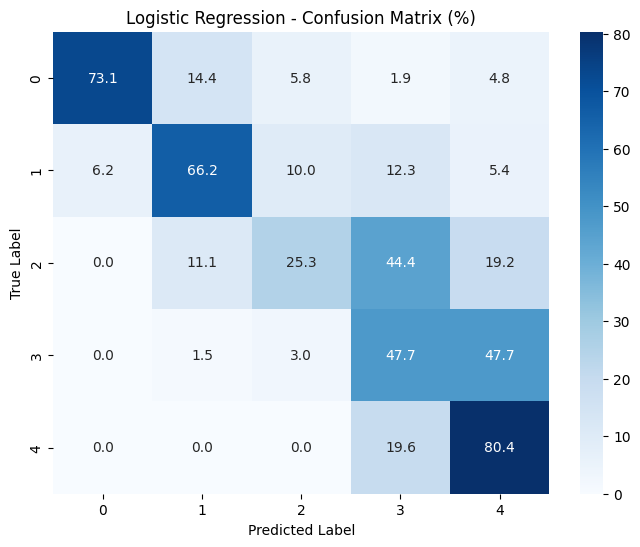

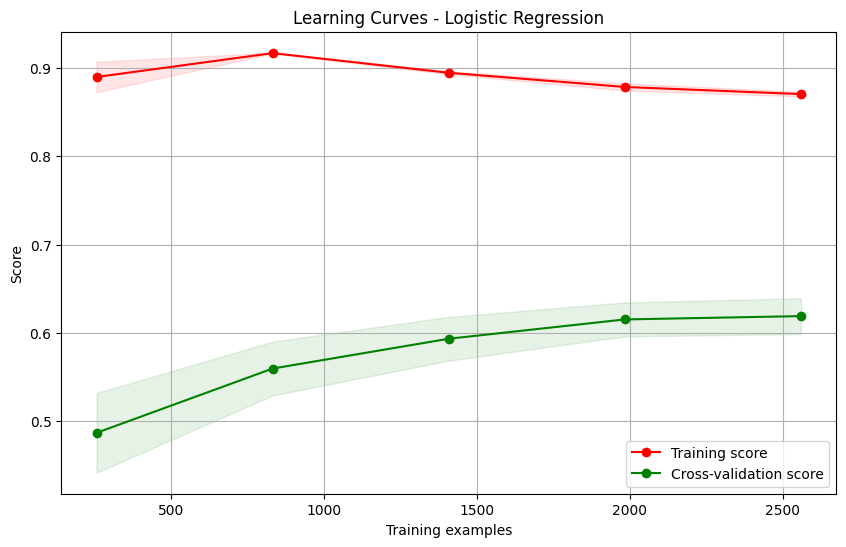


Grid Search Results for Logistic Regression:


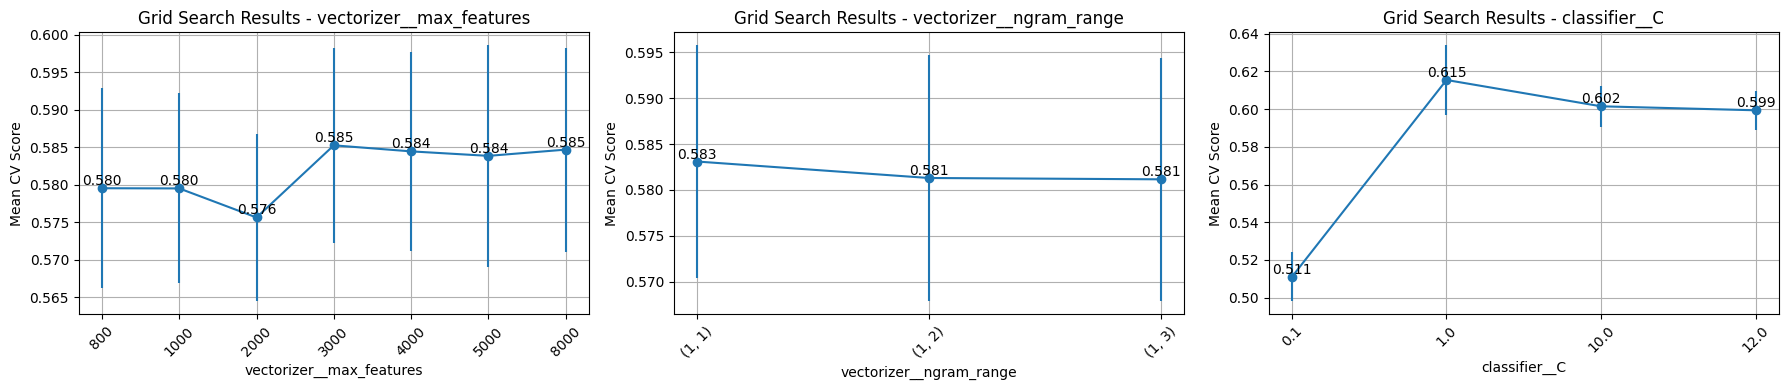


Top Features for Logistic Regression:


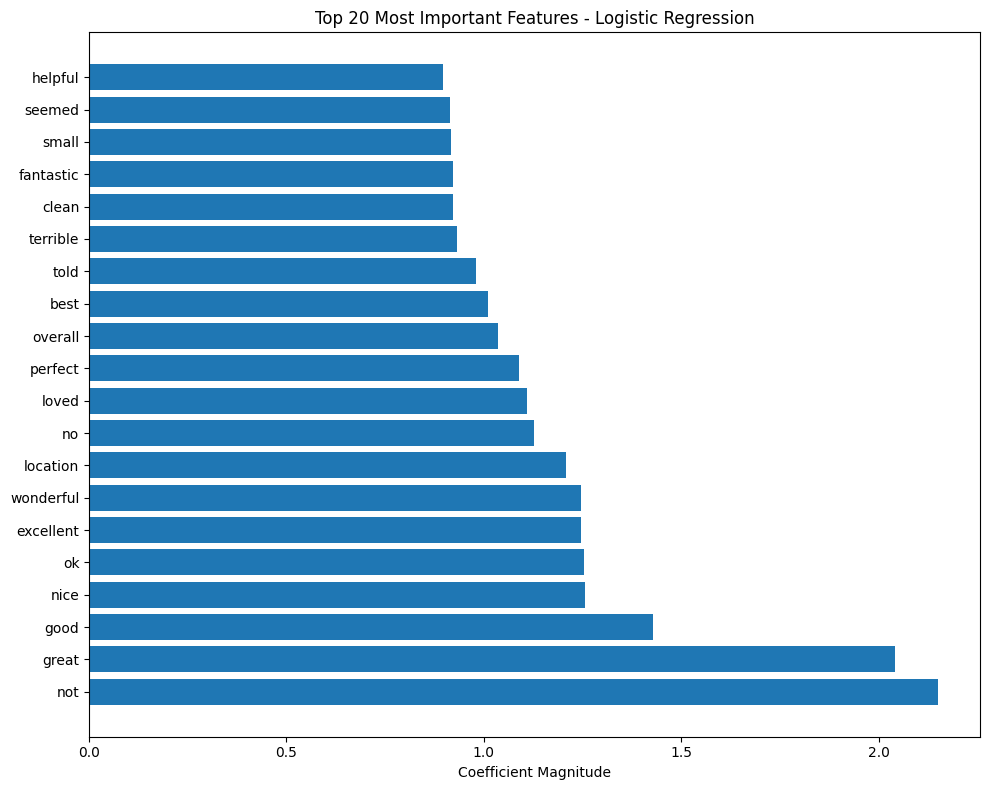


Class-specific Features for Logistic Regression:


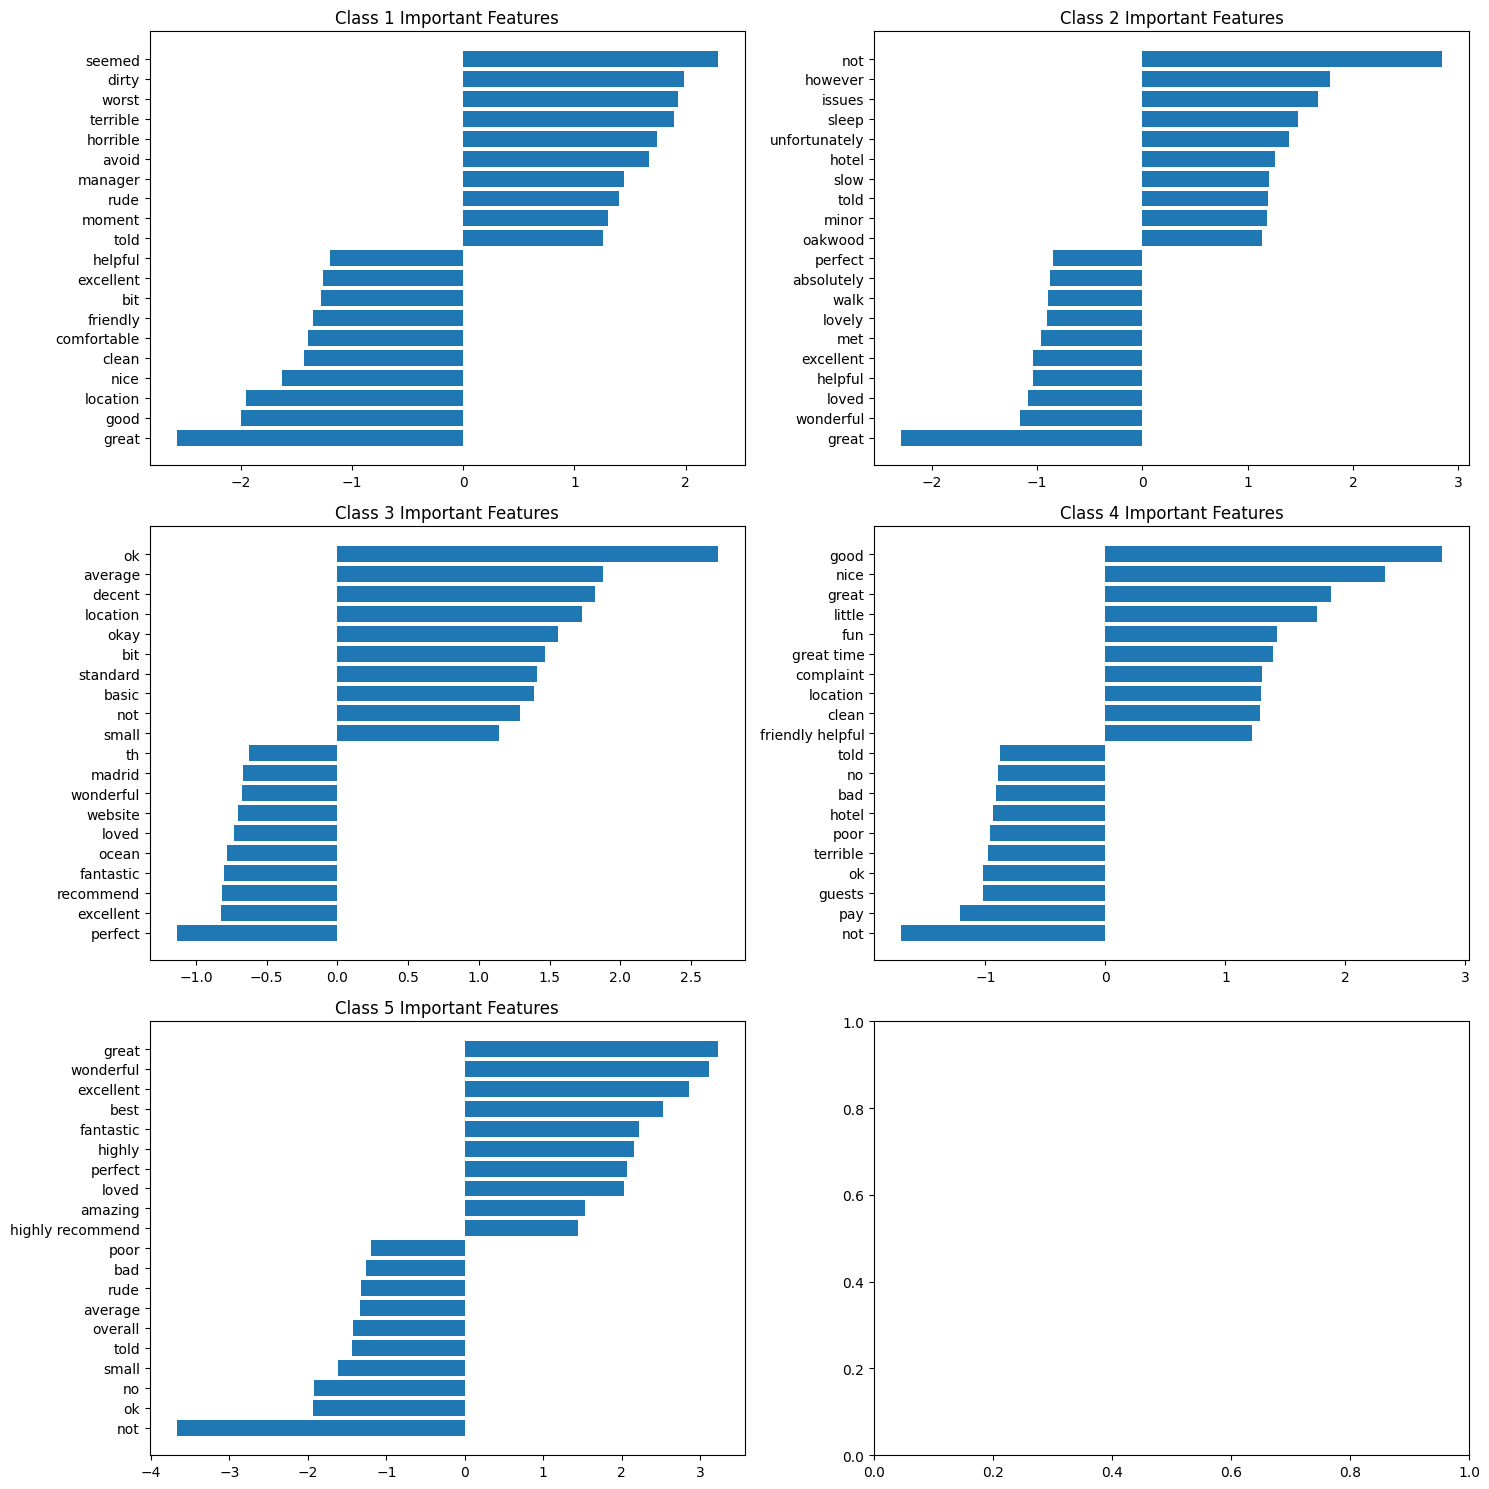


Training SVM with Grid Search...
Fitting 5 folds for each of 84 candidates, totalling 420 fits

SVM Results:
Best parameters: {'classifier__estimator__C': 0.1, 'vectorizer__max_features': 5000, 'vectorizer__ngram_range': (1, 1)}
Best CV score: 0.618
Training accuracy: 0.825
Testing accuracy: 0.610

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.77      0.79       104
           2       0.78      0.58      0.67       130
           3       0.50      0.18      0.27        99
           4       0.44      0.42      0.43       197
           5       0.61      0.86      0.71       270

    accuracy                           0.61       800
   macro avg       0.63      0.56      0.57       800
weighted avg       0.61      0.61      0.59       800



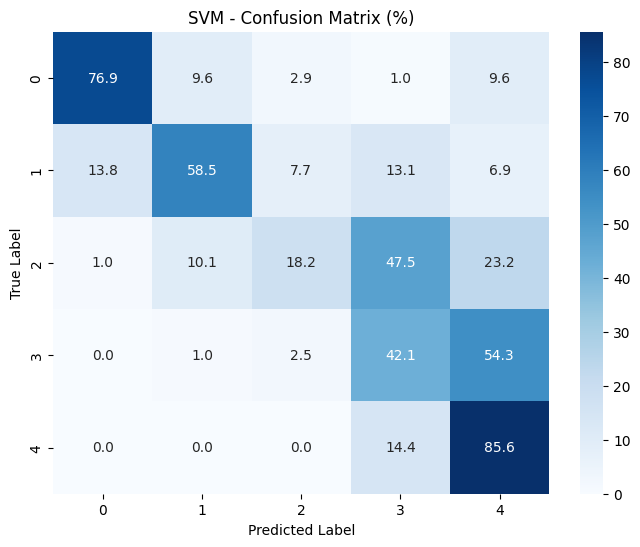

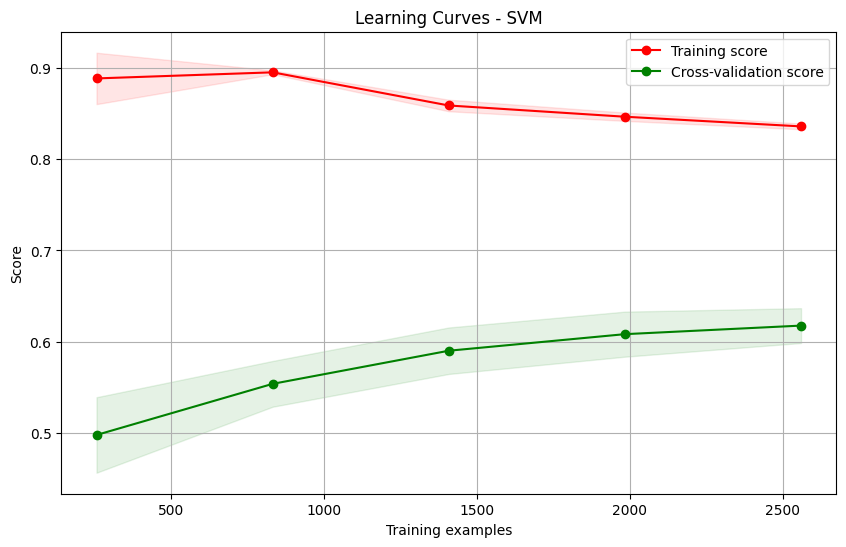


Grid Search Results for SVM:


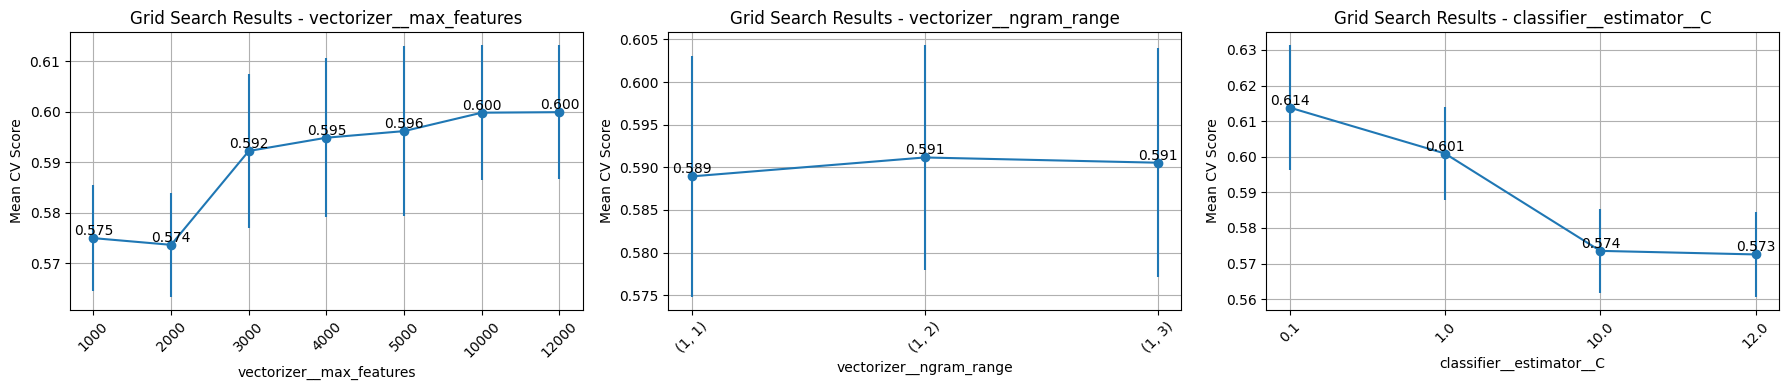


Top Features for SVM:
Could not plot feature importance for SVM: 'LinearSVC' object has no attribute 'coef_'

Class-specific Features for SVM:
Could not plot class-specific features for SVM: 'OneVsRestClassifier' object has no attribute 'coef_'

Training Random Forest with Grid Search...
Fitting 5 folds for each of 24 candidates, totalling 120 fits

Random Forest Results:
Best parameters: {'classifier__max_depth': None, 'classifier__n_estimators': 200, 'vectorizer__max_features': 1000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.590
Training accuracy: 1.000
Testing accuracy: 0.574

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.68      0.76       104
           2       0.71      0.58      0.64       130
           3       0.61      0.11      0.19        99
           4       0.39      0.40      0.40       197
           5       0.57      0.83      0.67       270

    accuracy                           0.57       800

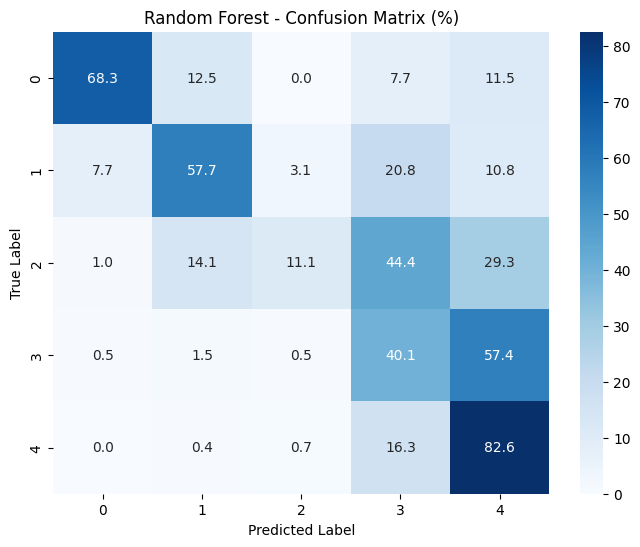

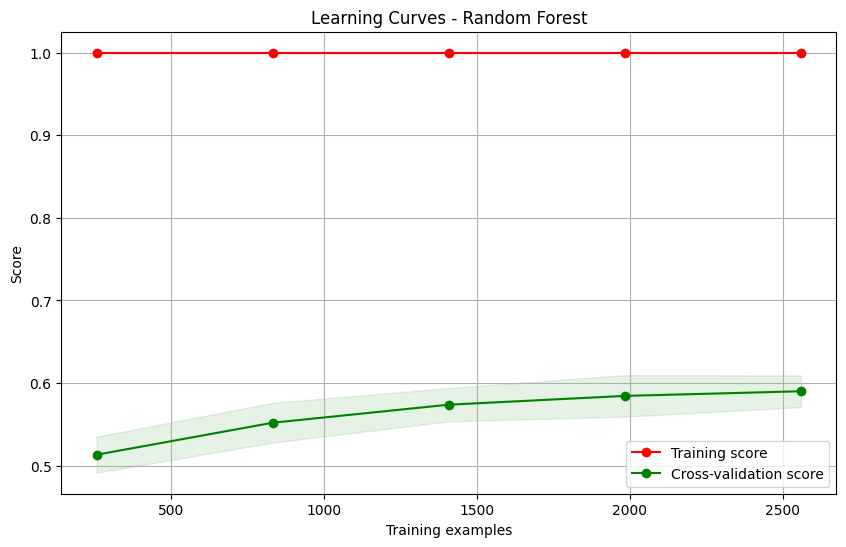


Grid Search Results for Random Forest:


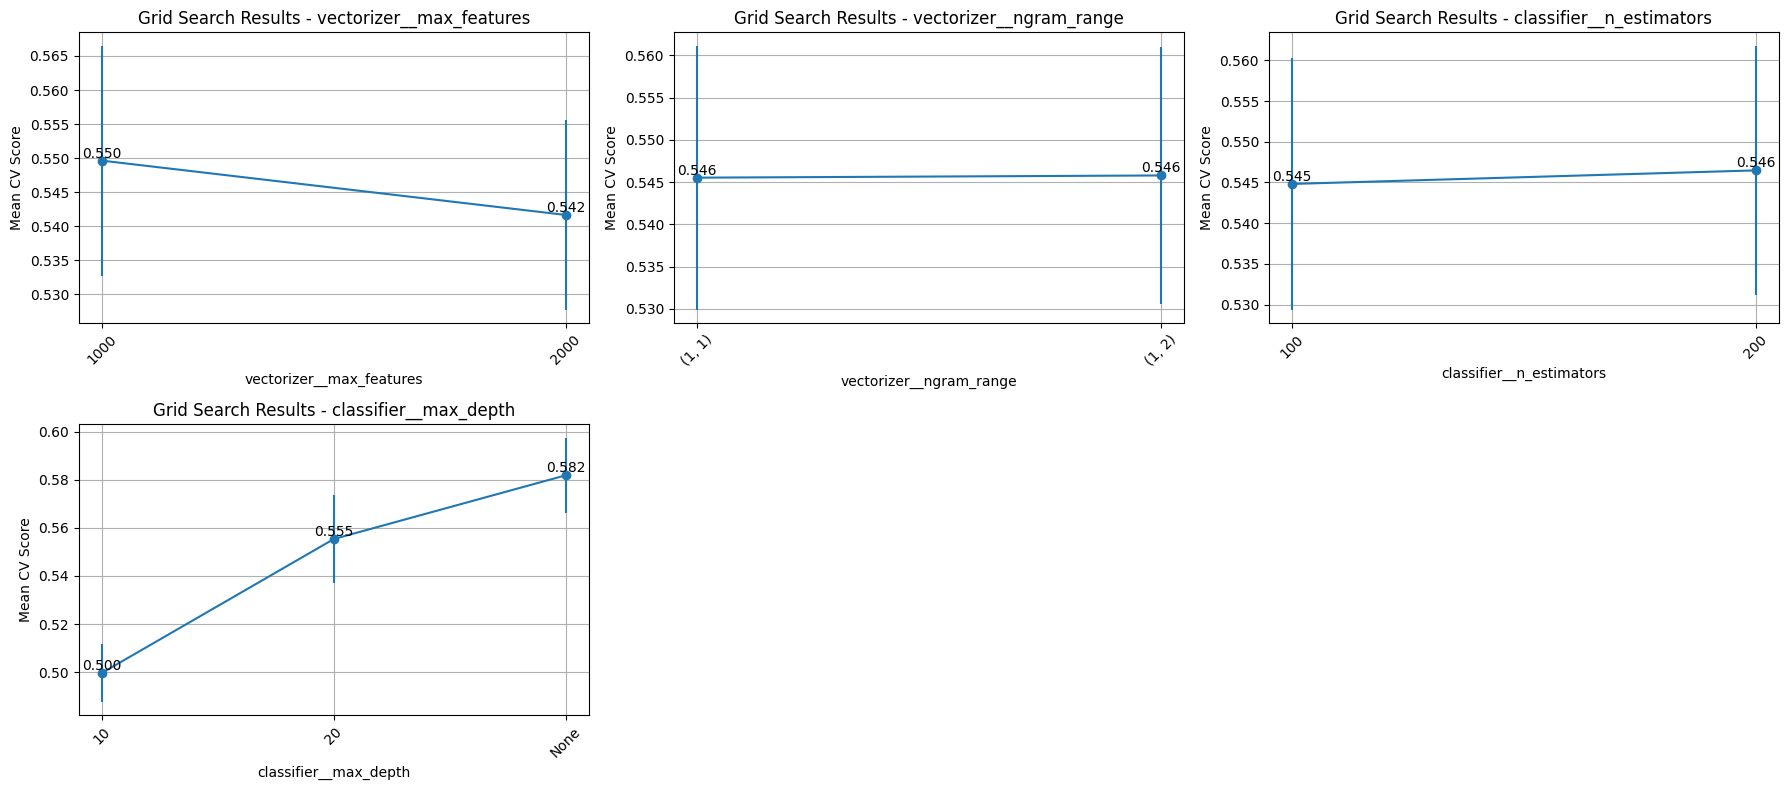


Top Features for Random Forest:


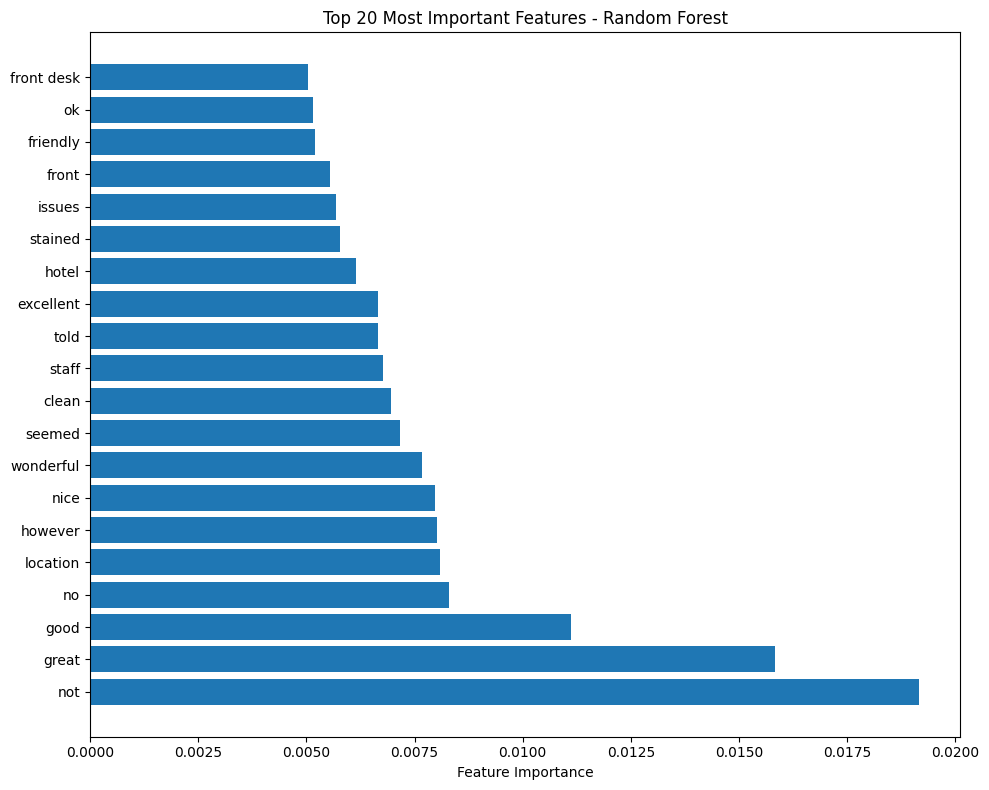


Class-specific Features for Random Forest:

Training Naive Bayes with Grid Search...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

Naive Bayes Results:
Best parameters: {'classifier__alpha': 0.1, 'vectorizer__max_features': 2000, 'vectorizer__ngram_range': (1, 2)}
Best CV score: 0.569
Training accuracy: 0.704
Testing accuracy: 0.550

Classification Report:
              precision    recall  f1-score   support

           1       0.86      0.57      0.68       104
           2       0.74      0.42      0.54       130
           3       0.28      0.07      0.11        99
           4       0.36      0.47      0.41       197
           5       0.61      0.84      0.70       270

    accuracy                           0.55       800
   macro avg       0.57      0.47      0.49       800
weighted avg       0.56      0.55      0.53       800



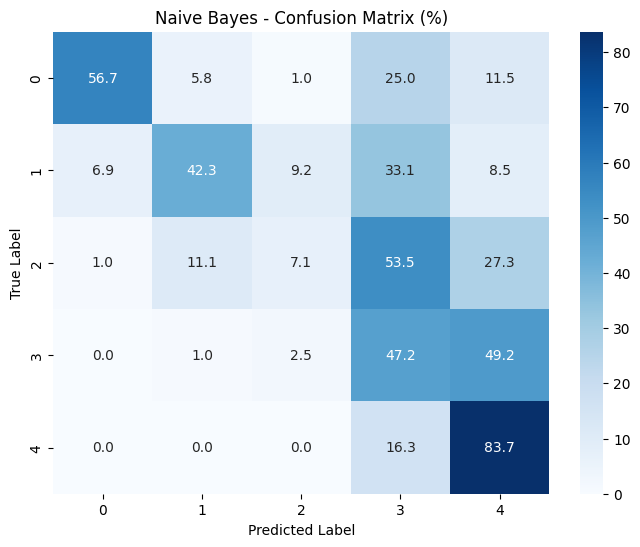

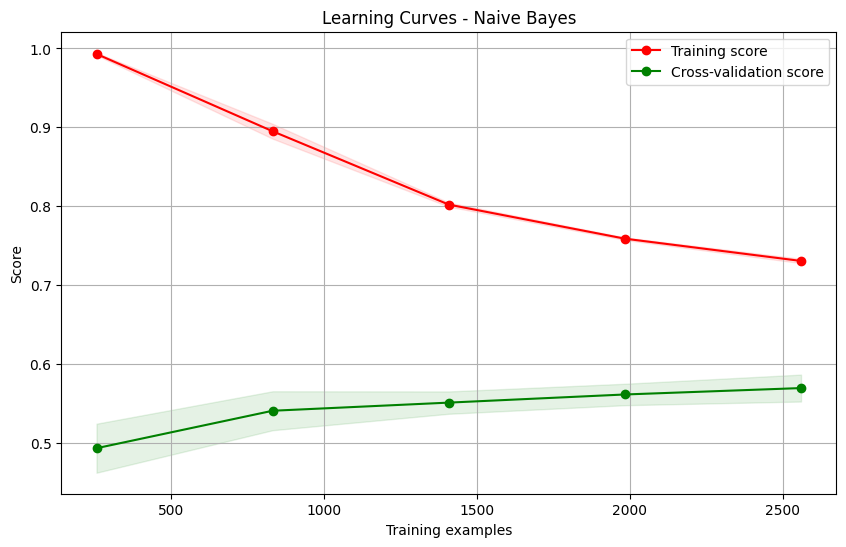


Grid Search Results for Naive Bayes:


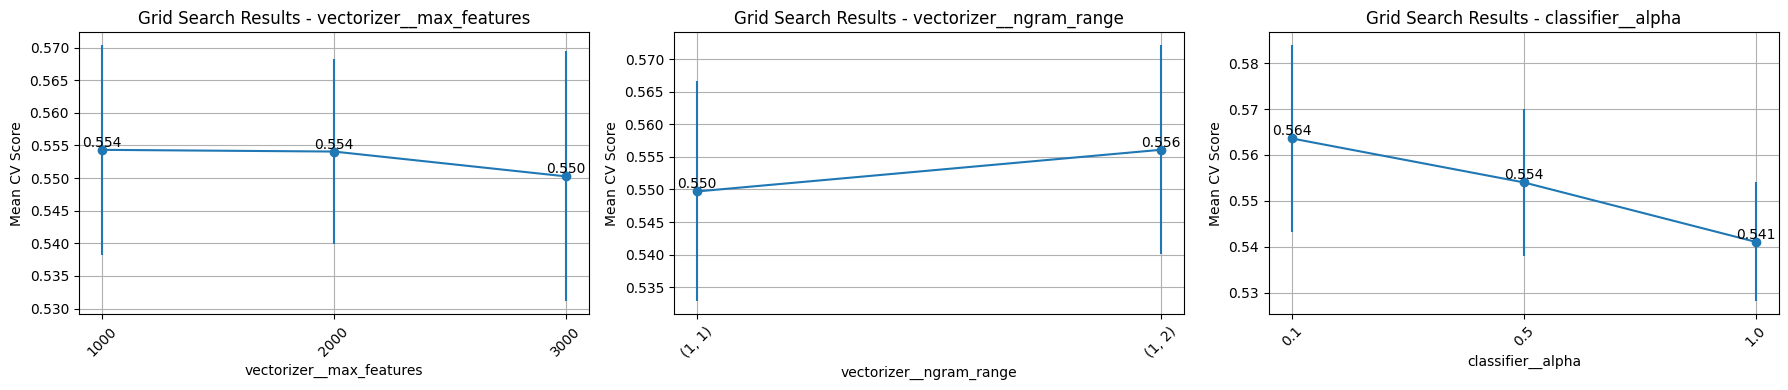


Top Features for Naive Bayes:


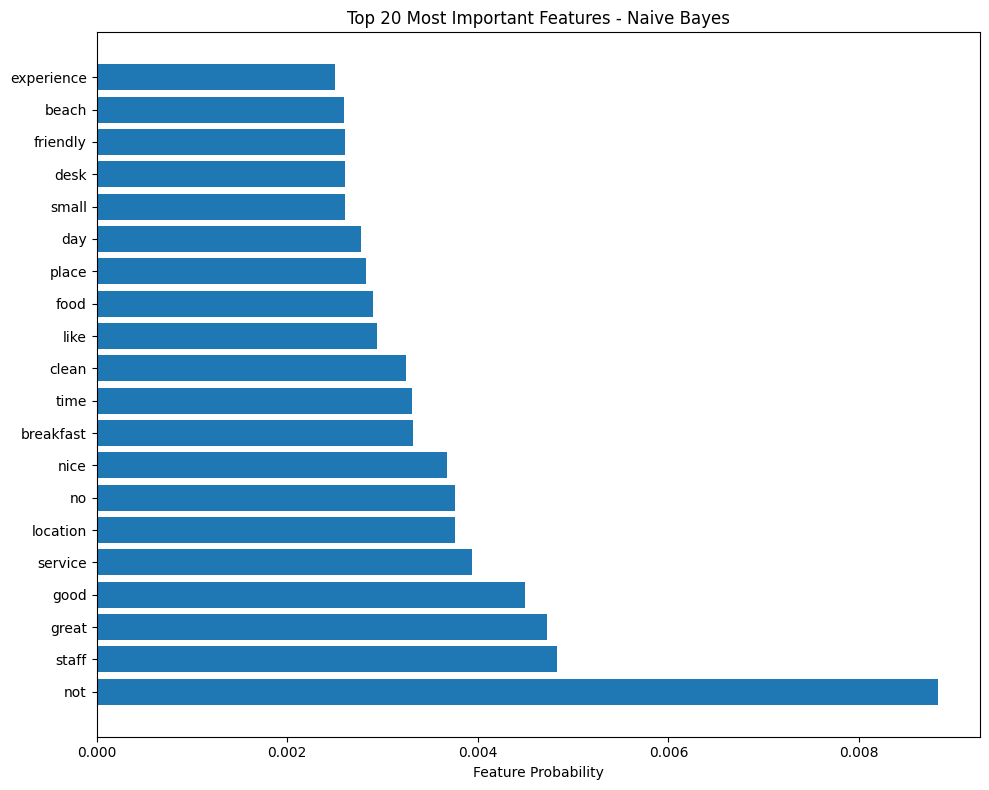


Class-specific Features for Naive Bayes:


In [26]:
# Compare models
results = compare_models_with_grid_search(X_train, X_test, y_train, y_test)

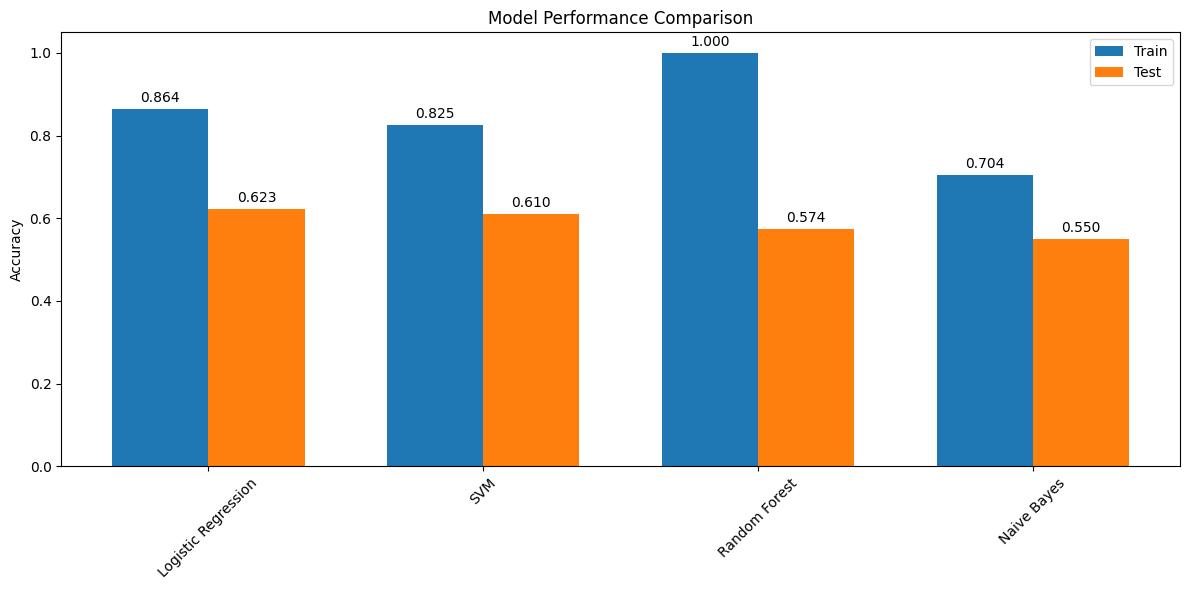

In [27]:
# Plot comparison
plot_model_comparison(results)